In [1]:
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

from ddim import BayesPredictor, CNNPredictor, Diffusion, create_alpha_schedule
from mnist_train import create_datasets

In [2]:
diffusion = Diffusion(
    create_alpha_schedule(num_steps=100, beta_0=0.001, beta_T=0.2)
)

In [3]:
def load_trained_model():
    model = CNNPredictor((1, 28, 28))
    model.load_state_dict(torch.load('checkpoints/mnist_model.pt'))
    return model

cnn_model = load_trained_model()

In [4]:
def create_bayes_models(num):
    loader, _ = create_datasets(1000, False)
    it = iter(loader)
    batch = next(it)[0]
    for _ in range(num):
        yield BayesPredictor(next(it)[0].numpy())

bayes_model, bayes_model_2 = create_bayes_models(2)

In [5]:
def load_test_data():
    _, loader = create_datasets(10000, False)
    batch = next(iter(loader))[0]
    return batch.numpy()

test_data = load_test_data()

In [6]:
def show_sample(sample):
    image = sample/0.3081 + 0.1307
    image = (image * 255).clip(0, 255).astype('uint8')
    image = image.reshape([4, 4, 1, 28, 28]).transpose(0, 3, 1, 4, 2).reshape([28*4, 28*4, 1])
    image = np.concatenate([image] * 3, axis=-1)
    display(Image.fromarray(image))

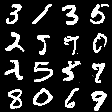

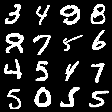

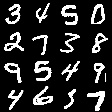

In [7]:
latents = np.random.normal(size=[16, 1, 28, 28])
cnn_sample = diffusion.ddim_sample(latents, cnn_model)
show_sample(cnn_sample)
bayes_sample = diffusion.ddim_sample(latents, bayes_model)
show_sample(bayes_sample)
bayes_2_sample = diffusion.ddim_sample(latents, bayes_model_2)
show_sample(bayes_2_sample)

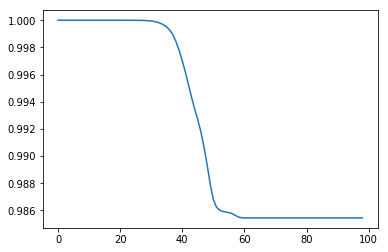

In [8]:
# Investigate how much the two bayes models
# agree during sampling.
x_t_1 = latents
x_t_2 = latents
correlations = []
for t in tqdm(range(1, diffusion.num_steps)[::-1]):
    ts = np.array([t] * latents.shape[0])
    alphas = diffusion.alphas_for_ts(ts)
    pred_1 = bayes_model.predict_epsilon(x_t_1, alphas)
    pred_2 = bayes_model_2.predict_epsilon(x_t_2, alphas)
    x_t_1 = diffusion.ddim_previous(x_t_1, ts, pred_1)
    x_t_2 = diffusion.ddim_previous(x_t_2, ts, pred_2)
    correlations.append(
        np.sum(pred_1 * pred_2) / np.sqrt(np.sum(pred_1 ** 2) * np.sum(pred_2 ** 2))
    )
plt.plot(correlations)
plt.show()

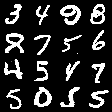

In [9]:
class HybridModel:
    def __init__(self, models, alphas):
        assert alphas[0] == 0
        assert len(models) == len(alphas)
        self.models = models
        self.alphas = alphas
        self.ranges = list(zip(alphas, alphas[1:]))
        self.ranges.append((alphas[-1], 1.0))

    def predict_epsilon(self, inputs, alphas):
        output = np.zeros_like(inputs)
        for i, (inp, alpha) in enumerate(zip(inputs, alphas)):
            for m, r in zip(self.models, self.ranges):
                if alpha >= r[0] and alpha <= r[1]:
                    output[i] = m.predict_epsilon(inp[None], alpha[None])[0]
                    break
        return output

hybrid = HybridModel(models=[bayes_model, cnn_model], alphas=[0, 0.2])
hybrid_sample = diffusion.ddim_sample(latents, hybrid)
show_sample(hybrid_sample)